In [1]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


## Data Generation Strategy

Since we're simulating a large-scale network monitoring scenario, we'll generate synthetic data that mimics real telecommunication networks:

- **10,000 devices** with multiple performance metrics
- **Time-series streams** with temporal dependencies
- **Injected anomalies** (point outliers, contextual, and collective)
- **Hierarchical structure** (devices → metrics → streams)

In [2]:
class NetworkDataGenerator:
    """Generate synthetic network monitoring data with realistic patterns"""
    
    def __init__(self, n_devices=1000, n_metrics=10, n_timesteps=1000, 
                 anomaly_ratio=0.05, seed=42):
        np.random.seed(seed)
        self.n_devices = n_devices
        self.n_metrics = n_metrics
        self.n_timesteps = n_timesteps
        self.anomaly_ratio = anomaly_ratio
        
        # Metric types for network monitoring
        self.metric_names = [
            'cpu_usage', 'memory_usage', 'bandwidth_in', 'bandwidth_out',
            'latency', 'packet_loss', 'error_rate', 'connection_count',
            'disk_io', 'temperature'
        ][:n_metrics]
        
    def generate_normal_stream(self, metric_type, length):
        """Generate normal behavior patterns with seasonality"""
        t = np.arange(length)
        
        # Base trend
        trend = 50 + 10 * np.sin(2 * np.pi * t / 100)
        
        # Daily seasonality
        seasonality = 15 * np.sin(2 * np.pi * t / 24)
        
        # Random noise
        noise = np.random.normal(0, 5, length)
        
        # Combine components
        signal = trend + seasonality + noise
        
        # Metric-specific adjustments
        if 'usage' in metric_type:
            signal = np.clip(signal, 0, 100)
        elif 'latency' in metric_type:
            signal = np.abs(signal) + 10
        elif 'packet_loss' in metric_type or 'error_rate' in metric_type:
            signal = np.clip(np.abs(signal) / 10, 0, 5)
        else:
            signal = np.clip(signal, 0, None)
            
        return signal
    
    def inject_anomalies(self, data, labels):
        """Inject various types of anomalies"""
        n_anomalies = int(len(data) * self.anomaly_ratio)
        anomaly_indices = np.random.choice(len(data), n_anomalies, replace=False)
        
        for idx in anomaly_indices:
            anomaly_type = np.random.choice(['point', 'contextual', 'collective'])
            
            if anomaly_type == 'point':
                # Point outlier: sudden spike
                data[idx] *= np.random.uniform(2.5, 4.0)
                labels[idx] = 1
                
            elif anomaly_type == 'contextual':
                # Contextual: value unusual for time of day
                data[idx] = np.random.uniform(80, 100)
                labels[idx] = 1
                
            elif anomaly_type == 'collective':
                # Collective: sustained unusual behavior
                duration = min(20, len(data) - idx)
                data[idx:idx+duration] *= np.random.uniform(1.5, 2.5)
                labels[idx:idx+duration] = 1
                
        return data, labels
    
    def generate_dataset(self):
        """Generate complete network monitoring dataset"""
        all_streams = []
        all_labels = []
        metadata = []
        
        print(f"Generating data for {self.n_devices} devices...")
        
        for device_id in range(self.n_devices):
            if (device_id + 1) % 200 == 0:
                print(f"  Generated {device_id + 1}/{self.n_devices} devices")
                
            for metric_idx, metric_name in enumerate(self.metric_names):
                # Generate normal stream
                stream = self.generate_normal_stream(metric_name, self.n_timesteps)
                labels = np.zeros(self.n_timesteps)
                
                # Inject anomalies in subset of streams
                if np.random.random() < 0.3:  # 30% of streams contain anomalies
                    stream, labels = self.inject_anomalies(stream.copy(), labels)
                
                all_streams.append(stream)
                all_labels.append(labels)
                metadata.append({
                    'device_id': device_id,
                    'metric_name': metric_name,
                    'stream_id': len(all_streams) - 1
                })
        
        print(f"✓ Generated {len(all_streams)} streams")
        
        # Convert to numpy arrays
        X = np.array(all_streams)  # Shape: (n_streams, n_timesteps)
        y = np.array(all_labels)
        
        # Create metadata DataFrame
        meta_df = pd.DataFrame(metadata)
        
        return X, y, meta_df

# Generate the dataset
print("="*60)
print("GENERATING NETWORK MONITORING DATASET")
print("="*60)

generator = NetworkDataGenerator(
    n_devices=1000,  # Reduced for demonstration
    n_metrics=10,
    n_timesteps=1000,
    anomaly_ratio=0.05,
    seed=42
)

X_raw, y_raw, metadata_df = generator.generate_dataset()

print(f"Dataset Shape: {X_raw.shape}")
print(f"Total Anomalies: {y_raw.sum()} ({100*y_raw.sum()/y_raw.size:.2f}%)")
print(f"Metadata Sample:")
print(metadata_df.head(10))

GENERATING NETWORK MONITORING DATASET
Generating data for 1000 devices...
  Generated 200/1000 devices
  Generated 400/1000 devices
  Generated 600/1000 devices
  Generated 800/1000 devices
  Generated 1000/1000 devices
✓ Generated 10000 streams
Dataset Shape: (10000, 1000)
Total Anomalies: 919085.0 (9.19%)
Metadata Sample:
   device_id       metric_name  stream_id
0          0         cpu_usage          0
1          0      memory_usage          1
2          0      bandwidth_in          2
3          0     bandwidth_out          3
4          0           latency          4
5          0       packet_loss          5
6          0        error_rate          6
7          0  connection_count          7
8          0           disk_io          8
9          0       temperature          9


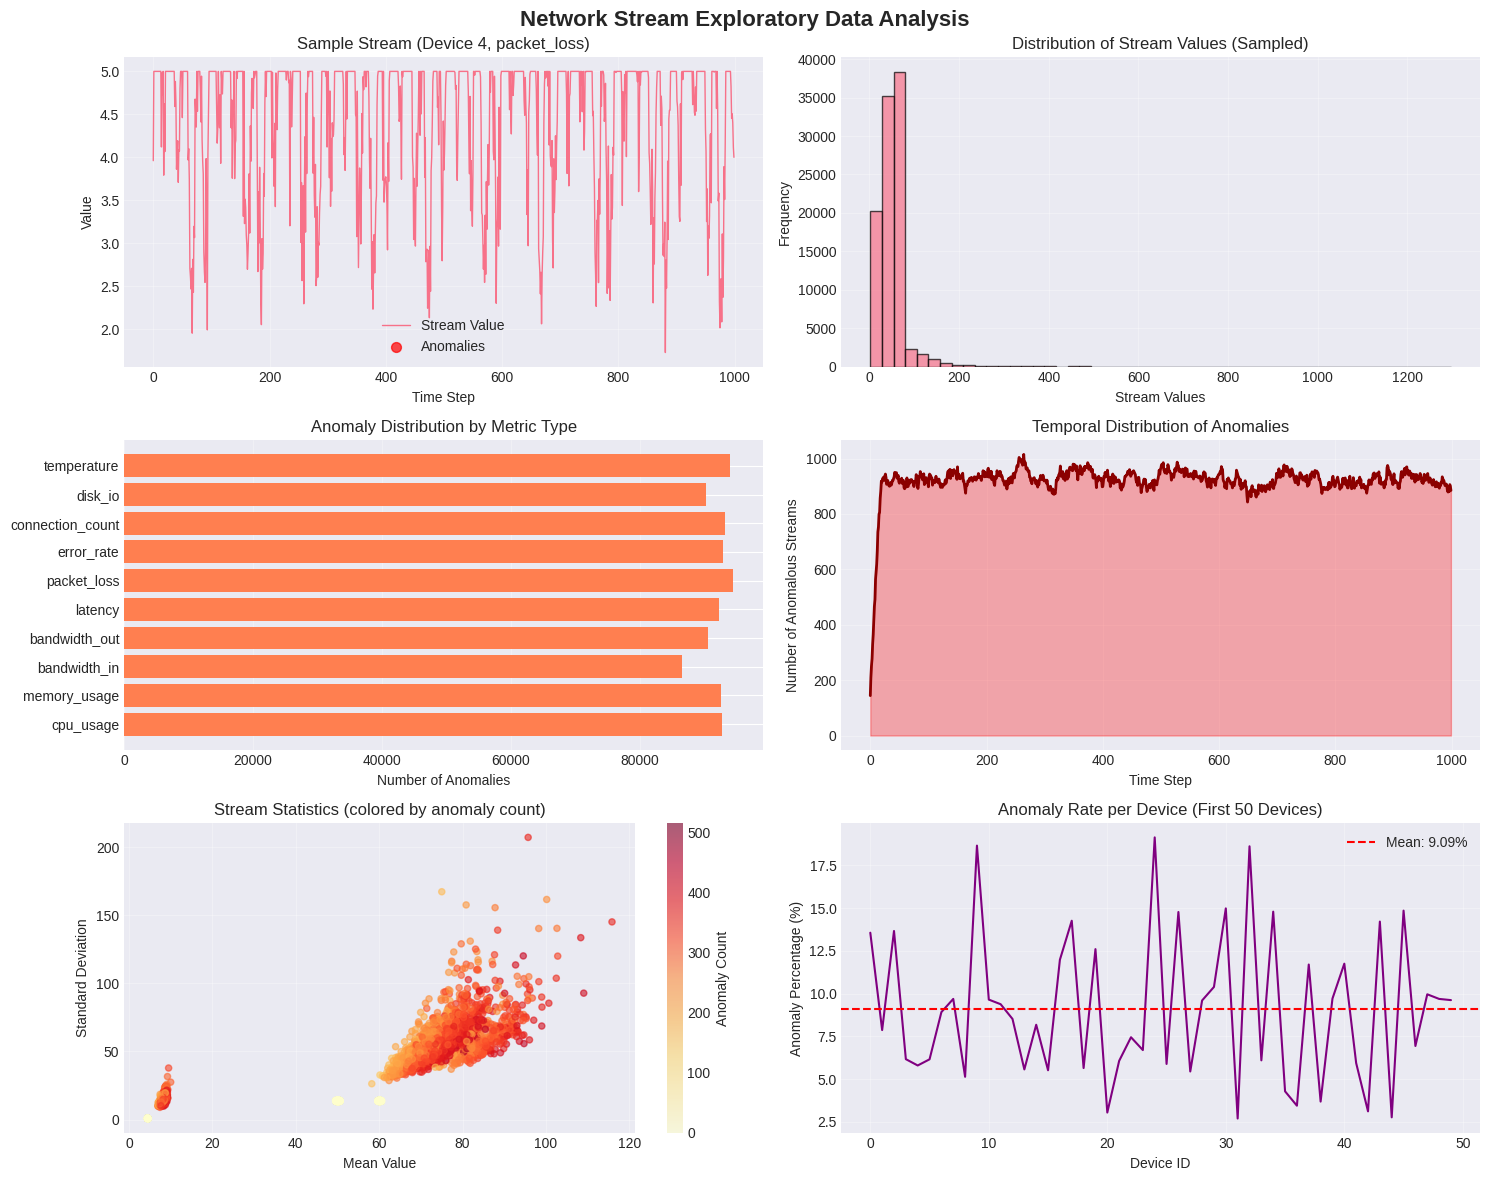

DATA SUMMARY STATISTICS
Total Streams: 10,000
Time Steps per Stream: 1,000
Total Data Points: 10,000,000
Anomaly Statistics:
  Total Anomalous Points: 919,085
  Anomaly Rate: 9.191%
  Streams with Anomalies: 2980
  Clean Streams: 7020
Value Statistics:
  Mean: 47.64
  Std Dev: 37.86
  Min: 0.52
  Max: 4447.18


In [3]:
# Create comprehensive EDA visualizations
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Network Stream Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Sample time series with anomalies
ax = axes[0, 0]
sample_stream_idx = 45  # Stream with anomalies
time_points = np.arange(len(X_raw[sample_stream_idx]))
ax.plot(time_points, X_raw[sample_stream_idx], label='Stream Value', linewidth=1)
anomaly_points = y_raw[sample_stream_idx] == 1
ax.scatter(time_points[anomaly_points], X_raw[sample_stream_idx][anomaly_points], 
           color='red', s=50, label='Anomalies', zorder=5, alpha=0.7)
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.set_title(f'Sample Stream (Device {metadata_df.iloc[sample_stream_idx]["device_id"]}, '
             f'{metadata_df.iloc[sample_stream_idx]["metric_name"]})')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Distribution of values across all streams
ax = axes[0, 1]
sample_values = X_raw.flatten()[::100]  # Sample for efficiency
ax.hist(sample_values, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Stream Values')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Stream Values (Sampled)')
ax.grid(True, alpha=0.3)

# 3. Anomaly distribution by metric type
ax = axes[1, 0]
anomaly_counts = []
metric_labels = []
for metric in generator.metric_names:
    metric_mask = metadata_df['metric_name'] == metric
    metric_anomalies = y_raw[metric_mask].sum()
    anomaly_counts.append(metric_anomalies)
    metric_labels.append(metric)

ax.barh(metric_labels, anomaly_counts, color='coral')
ax.set_xlabel('Number of Anomalies')
ax.set_title('Anomaly Distribution by Metric Type')
ax.grid(True, alpha=0.3, axis='x')

# 4. Temporal anomaly distribution
ax = axes[1, 1]
temporal_anomalies = y_raw.sum(axis=0)
ax.plot(temporal_anomalies, linewidth=2, color='darkred')
ax.fill_between(range(len(temporal_anomalies)), temporal_anomalies, alpha=0.3, color='red')
ax.set_xlabel('Time Step')
ax.set_ylabel('Number of Anomalous Streams')
ax.set_title('Temporal Distribution of Anomalies')
ax.grid(True, alpha=0.3)

# 5. Stream statistics correlation
ax = axes[2, 0]
stream_means = X_raw.mean(axis=1)
stream_stds = X_raw.std(axis=1)
scatter = ax.scatter(stream_means, stream_stds, c=y_raw.sum(axis=1), 
                     cmap='YlOrRd', alpha=0.6, s=20)
ax.set_xlabel('Mean Value')
ax.set_ylabel('Standard Deviation')
ax.set_title('Stream Statistics (colored by anomaly count)')
plt.colorbar(scatter, ax=ax, label='Anomaly Count')
ax.grid(True, alpha=0.3)

# 6. Anomaly percentage by device
ax = axes[2, 1]
device_anomaly_pct = []
for device_id in range(min(50, generator.n_devices)):  # First 50 devices
    device_mask = metadata_df['device_id'] == device_id
    device_data = y_raw[device_mask]
    if device_data.size > 0:
        pct = 100 * device_data.sum() / device_data.size
        device_anomaly_pct.append(pct)

ax.plot(device_anomaly_pct, linewidth=1.5, color='purple')
ax.axhline(y=np.mean(device_anomaly_pct), color='red', linestyle='--', 
           label=f'Mean: {np.mean(device_anomaly_pct):.2f}%')
ax.set_xlabel('Device ID')
ax.set_ylabel('Anomaly Percentage (%)')
ax.set_title('Anomaly Rate per Device (First 50 Devices)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("" + "="*60)
print("DATA SUMMARY STATISTICS")
print("="*60)
print(f"Total Streams: {X_raw.shape[0]:,}")
print(f"Time Steps per Stream: {X_raw.shape[1]:,}")
print(f"Total Data Points: {X_raw.size:,}")
print(f"Anomaly Statistics:")
print(f"  Total Anomalous Points: {int(y_raw.sum()):,}")
print(f"  Anomaly Rate: {100*y_raw.sum()/y_raw.size:.3f}%")
print(f"  Streams with Anomalies: {(y_raw.sum(axis=1) > 0).sum()}")
print(f"  Clean Streams: {(y_raw.sum(axis=1) == 0).sum()}")
print(f"Value Statistics:")
print(f"  Mean: {X_raw.mean():.2f}")
print(f"  Std Dev: {X_raw.std():.2f}")
print(f"  Min: {X_raw.min():.2f}")
print(f"  Max: {X_raw.max():.2f}")

FEATURE ENGINEERING
  Processed 1000/10000 streams
  Processed 2000/10000 streams
  Processed 3000/10000 streams
  Processed 4000/10000 streams
  Processed 5000/10000 streams
  Processed 6000/10000 streams
  Processed 7000/10000 streams
  Processed 8000/10000 streams
  Processed 9000/10000 streams
  Processed 10000/10000 streams
Feature extraction complete
Original shape: (10000, 1000)
Feature shape: (10000, 13)
Feature dimension: 13


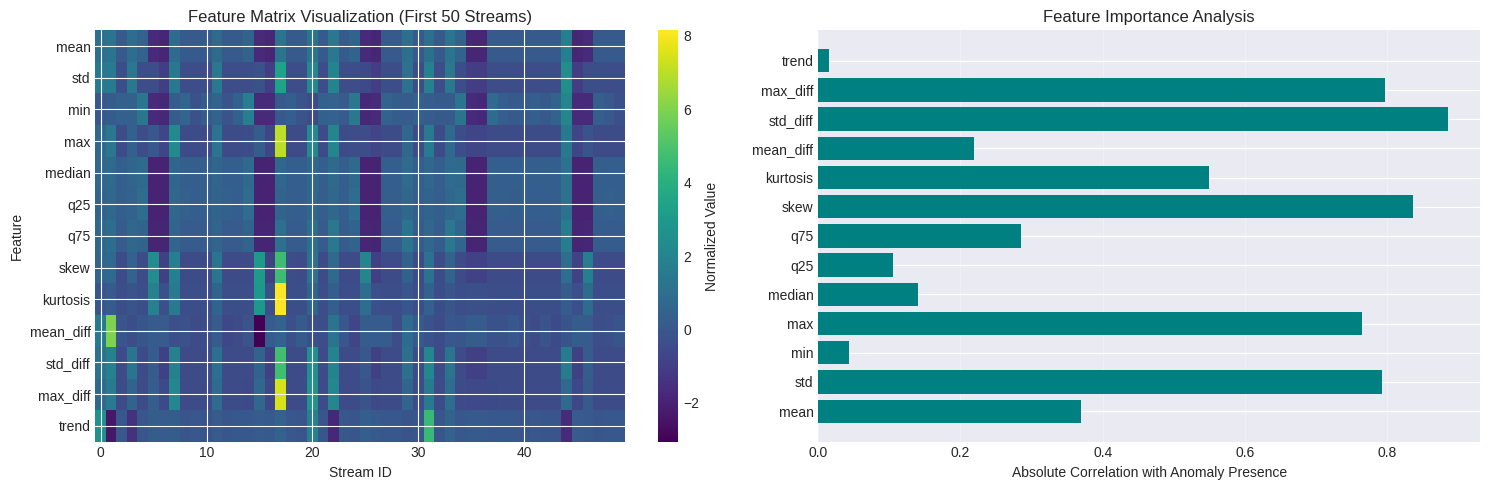

In [4]:
class FeatureExtractor:
    """Extract relevant features from time series streams"""
    
    def __init__(self, window_size=100):
        self.window_size = window_size
        self.scaler = StandardScaler()
        
    def extract_statistical_features(self, stream):
        """Extract statistical features from a stream"""
        features = {
            'mean': np.mean(stream),
            'std': np.std(stream),
            'min': np.min(stream),
            'max': np.max(stream),
            'median': np.median(stream),
            'q25': np.percentile(stream, 25),
            'q75': np.percentile(stream, 75),
            'skew': np.mean(((stream - np.mean(stream)) / np.std(stream)) ** 3),
            'kurtosis': np.mean(((stream - np.mean(stream)) / np.std(stream)) ** 4),
        }
        return features
    
    def extract_temporal_features(self, stream):
        """Extract temporal pattern features"""
        # First differences
        diffs = np.diff(stream)
        
        features = {
            'mean_diff': np.mean(diffs),
            'std_diff': np.std(diffs),
            'max_diff': np.max(np.abs(diffs)),
            'trend': np.polyfit(range(len(stream)), stream, 1)[0],
        }
        return features
    
    def extract_windowed_features(self, stream, window_size=None):
        """Extract features from sliding windows"""
        if window_size is None:
            window_size = self.window_size
            
        n_windows = len(stream) // window_size
        windowed_features = []
        
        for i in range(n_windows):
            window = stream[i*window_size:(i+1)*window_size]
            features = {
                **self.extract_statistical_features(window),
                **self.extract_temporal_features(window)
            }
            windowed_features.append(list(features.values()))
            
        return np.array(windowed_features)
    
    def transform_dataset(self, X, fit=True):
        """Transform entire dataset to feature representation"""
        all_features = []
        
        for i, stream in enumerate(X):
            if (i + 1) % 1000 == 0:
                print(f"  Processed {i+1}/{len(X)} streams")
                
            # Extract features for entire stream
            stat_features = self.extract_statistical_features(stream)
            temp_features = self.extract_temporal_features(stream)
            
            # Combine all features
            combined = {**stat_features, **temp_features}
            all_features.append(list(combined.values()))
        
        X_features = np.array(all_features)
        
        # Normalize features
        if fit:
            X_features = self.scaler.fit_transform(X_features)
        else:
            X_features = self.scaler.transform(X_features)
            
        return X_features

# Extract features
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

feature_extractor = FeatureExtractor(window_size=100)
X_features = feature_extractor.transform_dataset(X_raw)

print(f"Feature extraction complete")
print(f"Original shape: {X_raw.shape}")
print(f"Feature shape: {X_features.shape}")
print(f"Feature dimension: {X_features.shape[1]}")

# Visualize feature importance via correlation with anomalies
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Feature distributions
ax = axes[0]
feature_names = ['mean', 'std', 'min', 'max', 'median', 'q25', 'q75', 
                 'skew', 'kurtosis', 'mean_diff', 'std_diff', 'max_diff', 'trend']
im = ax.imshow(X_features[:50].T, aspect='auto', cmap='viridis')
ax.set_xlabel('Stream ID')
ax.set_ylabel('Feature')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.set_title('Feature Matrix Visualization (First 50 Streams)')
plt.colorbar(im, ax=ax, label='Normalized Value')

# Feature correlation with anomaly presence
ax = axes[1]
has_anomaly = (y_raw.sum(axis=1) > 0).astype(int)
correlations = []
for i in range(X_features.shape[1]):
    corr = np.corrcoef(X_features[:, i], has_anomaly)[0, 1]
    correlations.append(abs(corr))

ax.barh(feature_names, correlations, color='teal')
ax.set_xlabel('Absolute Correlation with Anomaly Presence')
ax.set_title('Feature Importance Analysis')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

HIERARCHICAL GROUPING & CONTEXTUAL ATTENTION
Built hierarchy with 1000 devices
Computed attention scores for 10000 groups
Selected 150 streams from top-150 groups


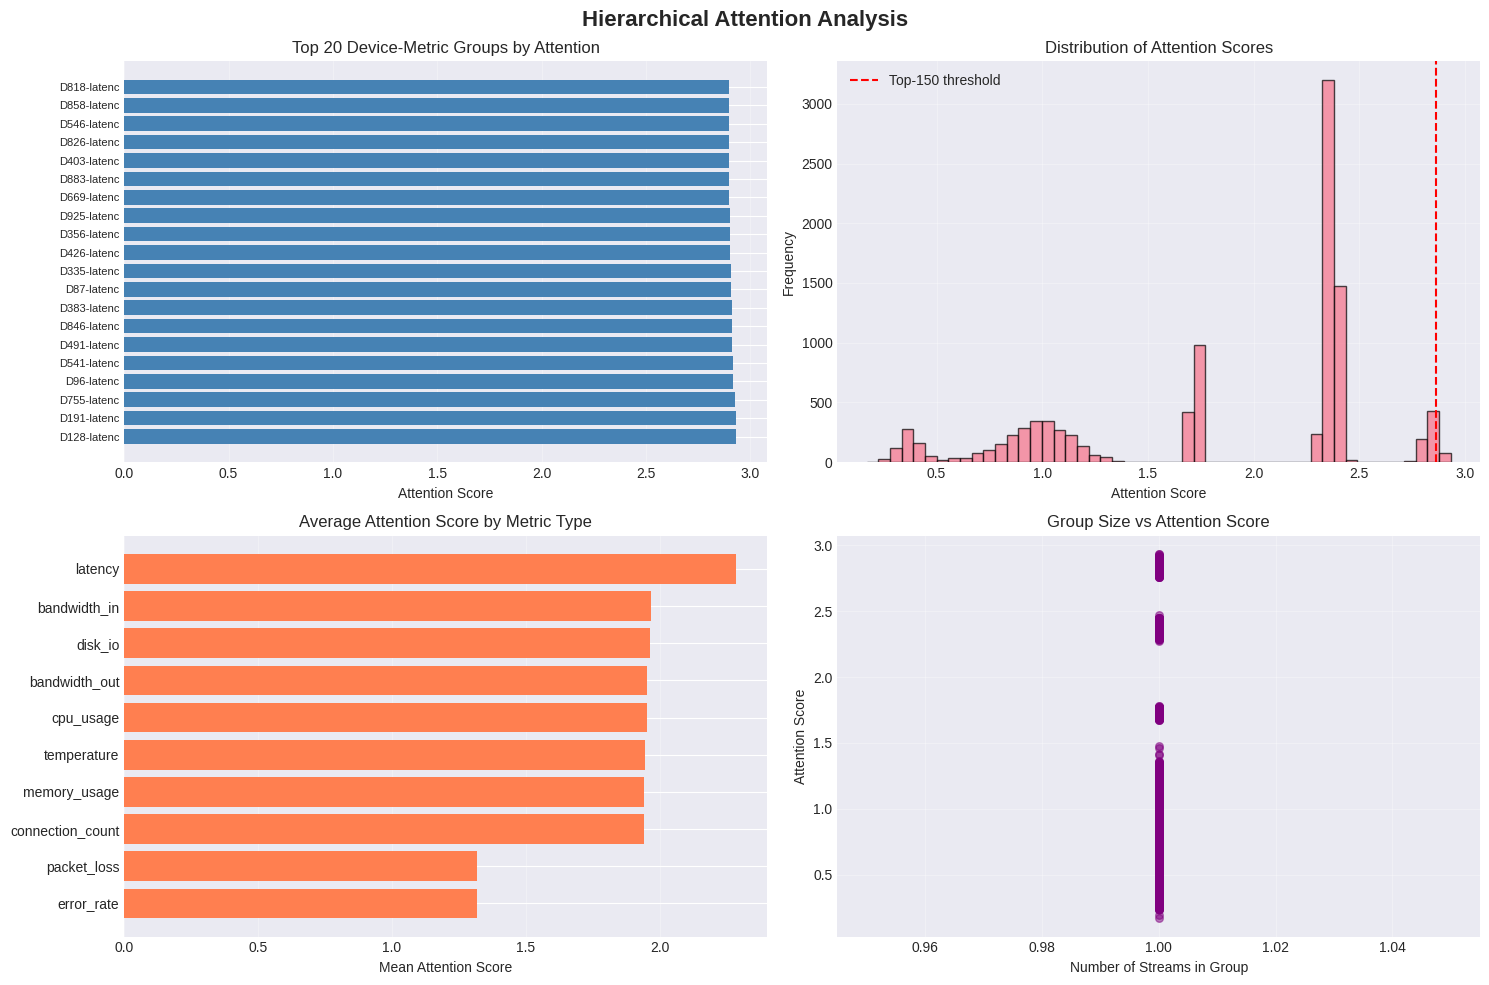

Top 10 Groups:
 device_id metric_name  attention_score  n_streams      mean       std
       128     latency         2.932785          1 60.182498 13.223793
       191     latency         2.930866          1 60.288499 13.258178
       755     latency         2.925405          1 60.106599 13.241694
        96     latency         2.916183          1 60.219848 13.313650
       541     latency         2.915490          1 60.070966 13.281653
       491     latency         2.913083          1 59.882930 13.248714
       846     latency         2.912202          1 60.174336 13.322384
       383     latency         2.911942          1 60.322161 13.358850
        87     latency         2.909730          1 60.193842 13.339198
       335     latency         2.908734          1 60.071921 13.315053


In [5]:
class HierarchicalAttention:
    """Implement Algorithm 1: Hierarchical Grouping and Contextual Attention"""
    
    def __init__(self, metadata_df):
        self.metadata = metadata_df
        self.hierarchy = defaultdict(lambda: defaultdict(list))
        
    def build_hierarchy(self, X, indices=None):
        """Build device -> metric -> streams hierarchy"""
        if indices is None:
            indices = range(len(X))
            
        self.hierarchy.clear()
        
        for idx in indices:
            device_id = self.metadata.iloc[idx]['device_id']
            metric_name = self.metadata.iloc[idx]['metric_name']
            stream_data = X[idx]
            
            self.hierarchy[device_id][metric_name].append({
                'stream_id': idx,
                'data': stream_data
            })
        
        return self.hierarchy
    
    def compute_attention_scores(self, X):
        """Compute attention scores for each device-metric group"""
        scores = []
        
        for device_id in self.hierarchy:
            for metric_name in self.hierarchy[device_id]:
                streams = self.hierarchy[device_id][metric_name]
                
                # Aggregate values from all streams in this group
                all_values = []
                for stream_info in streams:
                    all_values.extend(stream_info['data'])
                
                all_values = np.array(all_values)
                
                # Compute statistics
                mu = np.mean(all_values)
                sigma = np.std(all_values) + 1e-8
                n = len(streams)
                
                # Attention score: prioritize high magnitude, low variance, more streams
                attention_score = (abs(mu) * np.log(1 + n)) / (1 + sigma)
                
                scores.append({
                    'device_id': device_id,
                    'metric_name': metric_name,
                    'attention_score': attention_score,
                    'n_streams': n,
                    'mean': mu,
                    'std': sigma
                })
        
        return pd.DataFrame(scores).sort_values('attention_score', ascending=False)
    
    def select_top_groups(self, attention_df, k=100):
        """Select top-k groups by attention score"""
        top_groups = attention_df.head(k)
        
        # Get stream indices for these groups
        selected_indices = []
        for _, row in top_groups.iterrows():
            device_id = row['device_id']
            metric_name = row['metric_name']
            
            for stream_info in self.hierarchy[device_id][metric_name]:
                selected_indices.append(stream_info['stream_id'])
        
        return selected_indices, top_groups

# Apply hierarchical attention
print("="*60)
print("HIERARCHICAL GROUPING & CONTEXTUAL ATTENTION")
print("="*60)

hierarchical_attn = HierarchicalAttention(metadata_df)
hierarchy = hierarchical_attn.build_hierarchy(X_raw)

print(f"Built hierarchy with {len(hierarchy)} devices")

# Compute attention scores
attention_scores = hierarchical_attn.compute_attention_scores(X_raw)
print(f"Computed attention scores for {len(attention_scores)} groups")

# Select top groups
top_k = 150
selected_indices, top_groups = hierarchical_attn.select_top_groups(attention_scores, k=top_k)
print(f"Selected {len(selected_indices)} streams from top-{top_k} groups")

# Visualize attention scores
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Hierarchical Attention Analysis', fontsize=16, fontweight='bold')

# 1. Top attention scores
ax = axes[0, 0]
top_20 = attention_scores.head(20)
labels = [f"D{row['device_id']}-{row['metric_name'][:6]}" for _, row in top_20.iterrows()]
ax.barh(range(len(top_20)), top_20['attention_score'], color='steelblue')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(labels, fontsize=8)
ax.set_xlabel('Attention Score')
ax.set_title('Top 20 Device-Metric Groups by Attention')
ax.grid(True, alpha=0.3, axis='x')

# 2. Attention score distribution
ax = axes[0, 1]
ax.hist(attention_scores['attention_score'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(x=top_groups['attention_score'].min(), color='red', linestyle='--',
           label=f'Top-{top_k} threshold')
ax.set_xlabel('Attention Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Attention Scores')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Attention by metric type
ax = axes[1, 0]
metric_attention = attention_scores.groupby('metric_name')['attention_score'].mean().sort_values()
ax.barh(metric_attention.index, metric_attention.values, color='coral')
ax.set_xlabel('Mean Attention Score')
ax.set_title('Average Attention Score by Metric Type')
ax.grid(True, alpha=0.3, axis='x')

# 4. Group size vs attention
ax = axes[1, 1]
ax.scatter(attention_scores['n_streams'], attention_scores['attention_score'], 
           alpha=0.5, s=30, color='purple')
ax.set_xlabel('Number of Streams in Group')
ax.set_ylabel('Attention Score')
ax.set_title('Group Size vs Attention Score')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"{'='*60}")
print("Top 10 Groups:")
print(top_groups.head(10).to_string(index=False))

SPARSE ADAPTIVE SAMPLING
 Sampled 150 streams from 150 candidates
  Exploitation: 150 streams
  Exploration: 0 streams
  Anomaly Coverage:
  Overall anomaly rate: 9.191%
  Sampled anomaly rate: 0.000%
  Coverage ratio: 0.00x


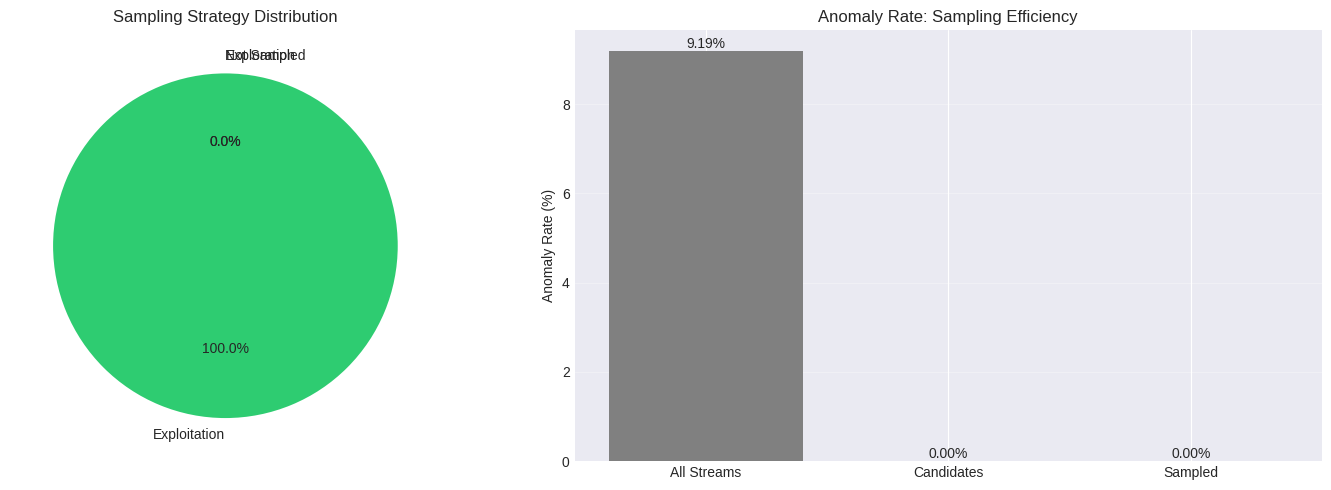

In [6]:
class SparseAdaptiveSampler:
    """Implement Algorithm 2: Sparse Adaptive Sampling"""
    
    def __init__(self, exploit_ratio=0.7, explore_ratio=0.1):
        self.exploit_ratio = exploit_ratio
        self.explore_ratio = explore_ratio
        self.rolling_scores = {}
        self.alpha = 0.3  # EMA parameter
        
    def update_rolling_scores(self, stream_indices, anomaly_scores):
        """Update rolling anomaly scores using exponential moving average"""
        for idx, score in zip(stream_indices, anomaly_scores):
            if idx in self.rolling_scores:
                # EMA update
                self.rolling_scores[idx] = (self.alpha * score + 
                                           (1 - self.alpha) * self.rolling_scores[idx])
            else:
                self.rolling_scores[idx] = score
    
    def sample_streams(self, candidate_indices, attention_scores, n_sample):
        """Sample streams using exploitation-exploration strategy"""
        # Get attention and rolling scores for candidates
        candidate_attention = {idx: attention_scores.get(idx, 0) 
                              for idx in candidate_indices}
        candidate_rolling = {idx: self.rolling_scores.get(idx, 0) 
                            for idx in candidate_indices}
        
        # Combine scores (attention + rolling anomaly)
        combined_scores = {idx: candidate_attention[idx] + candidate_rolling[idx] 
                          for idx in candidate_indices}
        
        # Exploitation: select top streams
        n_exploit = int(n_sample * self.exploit_ratio)
        sorted_indices = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
        exploit_indices = [idx for idx, _ in sorted_indices[:n_exploit]]
        
        # Exploration: random sample from remaining
        remaining = [idx for idx in candidate_indices if idx not in exploit_indices]
        n_explore = min(int(n_sample * self.explore_ratio), len(remaining))
        explore_indices = np.random.choice(remaining, n_explore, replace=False).tolist()
        
        sampled = exploit_indices + explore_indices
        
        return sampled, {
            'n_exploit': len(exploit_indices),
            'n_explore': len(explore_indices),
            'total': len(sampled)
        }

# Initialize sampler
print("="*60)
print("SPARSE ADAPTIVE SAMPLING")
print("="*60)

sampler = SparseAdaptiveSampler(exploit_ratio=0.7, explore_ratio=0.1)

# Create attention score mapping
attention_mapping = {}
for idx in selected_indices:
    device_id = metadata_df.iloc[idx]['device_id']
    metric_name = metadata_df.iloc[idx]['metric_name']
    
    # Find attention score for this stream's group
    group_score = attention_scores[
        (attention_scores['device_id'] == device_id) & 
        (attention_scores['metric_name'] == metric_name)
    ]['attention_score'].values
    
    attention_mapping[idx] = group_score[0] if len(group_score) > 0 else 0

# Initialize rolling scores with random values (simulating previous detections)
for idx in selected_indices[:100]:
    sampler.rolling_scores[idx] = np.random.uniform(0, 0.5)

# Perform sampling
n_to_sample = 800
sampled_indices, sample_stats = sampler.sample_streams(
    selected_indices, attention_mapping, n_to_sample
)

print(f" Sampled {len(sampled_indices)} streams from {len(selected_indices)} candidates")
print(f"  Exploitation: {sample_stats['n_exploit']} streams")
print(f"  Exploration: {sample_stats['n_explore']} streams")

# Analyze sampled vs not sampled streams
sampled_mask = np.isin(range(len(X_raw)), sampled_indices)
sampled_anomaly_rate = y_raw[sampled_mask].sum() / y_raw[sampled_mask].size
total_anomaly_rate = y_raw.sum() / y_raw.size

print(f"  Anomaly Coverage:")
print(f"  Overall anomaly rate: {100*total_anomaly_rate:.3f}%")
print(f"  Sampled anomaly rate: {100*sampled_anomaly_rate:.3f}%")
print(f"  Coverage ratio: {sampled_anomaly_rate/total_anomaly_rate:.2f}x")

# Visualize sampling strategy
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Sampled vs candidate streams
ax = axes[0]
sample_types = ['Exploitation', 'Exploration', 'Not Sampled']
counts = [
    sample_stats['n_exploit'],
    sample_stats['n_explore'],
    len(selected_indices) - len(sampled_indices)
]
colors = ['#2ecc71', '#3498db', '#95a5a6']
ax.pie(counts, labels=sample_types, autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('Sampling Strategy Distribution')

# 2. Anomaly rate comparison
ax = axes[1]
categories = ['All Streams', 'Candidates', 'Sampled']
rates = [
    100 * total_anomaly_rate,
    100 * y_raw[selected_indices].sum() / y_raw[selected_indices].size,
    100 * sampled_anomaly_rate
]
bars = ax.bar(categories, rates, color=['gray', 'orange', 'green'])
ax.set_ylabel('Anomaly Rate (%)')
ax.set_title('Anomaly Rate: Sampling Efficiency')
ax.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rates[i]:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

SEMI-SUPERVISED DIMENSIONALITY REDUCTION
Training data shape: (150, 13)
Anomalous samples: 0.0 (0.00%)
  Model architecture:
  Input dim: 13
  Latent dim: 16
  Parameters: 7,389
Training autoencoder...
  Epoch 10/50 - Loss: 0.3726 (Recon: 0.3726, Contrast: 0.0000)
  Epoch 20/50 - Loss: 0.1283 (Recon: 0.1283, Contrast: 0.0000)
  Epoch 30/50 - Loss: 0.0104 (Recon: 0.0104, Contrast: 0.0000)
  Epoch 40/50 - Loss: 0.0038 (Recon: 0.0038, Contrast: 0.0000)
  Epoch 50/50 - Loss: 0.0032 (Recon: 0.0032, Contrast: 0.0000)
 Training complete
Latent representation shape: (150, 16)


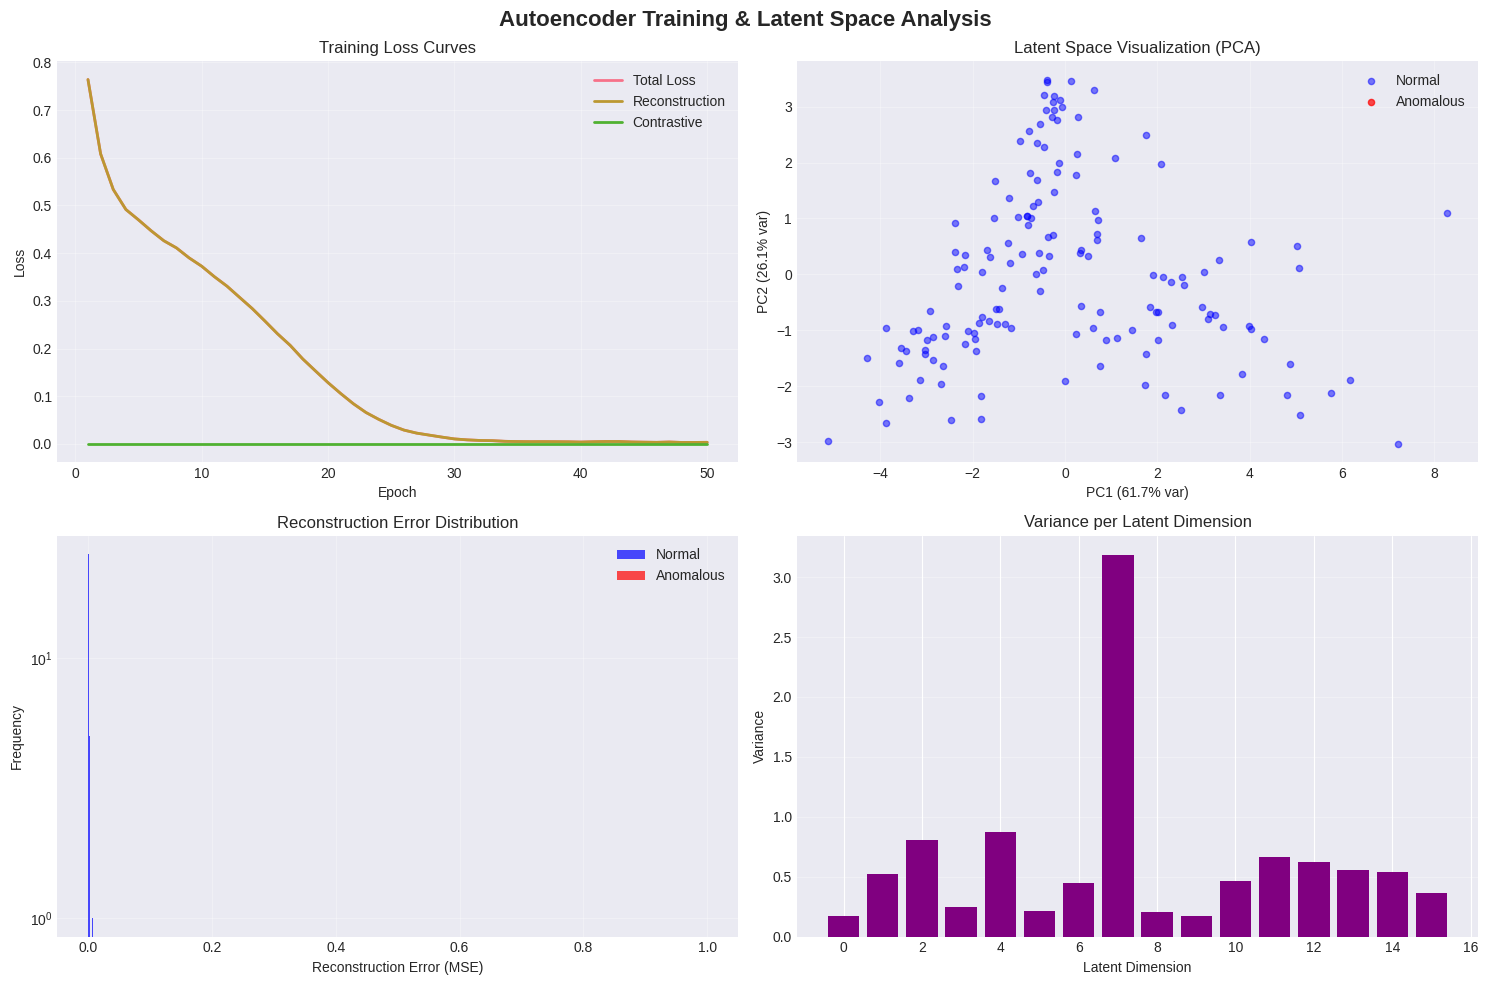

  Reconstruction Error Statistics:
  Normal streams: 0.0014 ± 0.0012
  Anomalous streams: nan ± nan


In [7]:
class SemiSupervisedAutoencoder(nn.Module):
    """Autoencoder with contrastive loss for anomaly-aware feature learning"""
    
    def __init__(self, input_dim, latent_dim=16):
        super(SemiSupervisedAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, input_dim)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

def contrastive_loss(z, labels, temperature=0.5):
    """Contrastive loss to separate normal and anomalous samples"""
    # Normalize embeddings
    z = torch.nn.functional.normalize(z, dim=1)
    
    # Compute similarity matrix
    similarity = torch.matmul(z, z.T) / temperature
    
    # Create positive pair mask (same label)
    labels = labels.unsqueeze(1)
    mask = torch.eq(labels, labels.T).float()
    
    # Compute loss
    exp_sim = torch.exp(similarity)
    log_prob = similarity - torch.log(exp_sim.sum(dim=1, keepdim=True))
    mean_log_prob = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)
    loss = -mean_log_prob.mean()
    
    return loss

def train_autoencoder(model, X_train, y_train, epochs=50, batch_size=32, lambda_contrastive=0.3):
    """Train the semi-supervised autoencoder"""
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    mse_loss = nn.MSELoss()
    
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.FloatTensor(y_train)
    
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    losses = {'total': [], 'reconstruction': [], 'contrastive': []}
    
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_recon_loss = 0
        epoch_contrast_loss = 0
        
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, latent = model(batch_x)
            
            # Reconstruction loss
            recon_loss = mse_loss(reconstructed, batch_x)
            
            # Contrastive loss (only if we have labeled samples)
            if batch_y.sum() > 0:
                contrast_loss = contrastive_loss(latent, batch_y)
            else:
                contrast_loss = torch.tensor(0.0)
            
            # Combined loss
            total_loss = recon_loss + lambda_contrastive * contrast_loss
            
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_contrast_loss += contrast_loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        avg_recon = epoch_recon_loss / len(dataloader)
        avg_contrast = epoch_contrast_loss / len(dataloader)
        
        losses['total'].append(avg_loss)
        losses['reconstruction'].append(avg_recon)
        losses['contrastive'].append(avg_contrast)
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} "
                  f"(Recon: {avg_recon:.4f}, Contrast: {avg_contrast:.4f})")
    
    return model, losses

# Prepare training data (using sampled streams)
print("="*60)
print("SEMI-SUPERVISED DIMENSIONALITY REDUCTION")
print("="*60)

X_sampled = X_features[sampled_indices]
y_sampled = (y_raw[sampled_indices].sum(axis=1) > 0).astype(float)

print(f"Training data shape: {X_sampled.shape}")
print(f"Anomalous samples: {y_sampled.sum()} ({100*y_sampled.mean():.2f}%)")

# Initialize and train autoencoder
input_dim = X_sampled.shape[1]
latent_dim = 16

autoencoder = SemiSupervisedAutoencoder(input_dim, latent_dim)
print(f"  Model architecture:")
print(f"  Input dim: {input_dim}")
print(f"  Latent dim: {latent_dim}")
print(f"  Parameters: {sum(p.numel() for p in autoencoder.parameters()):,}")

print("Training autoencoder...")
autoencoder, training_losses = train_autoencoder(
    autoencoder, X_sampled, y_sampled, 
    epochs=50, batch_size=32, lambda_contrastive=0.3
)

print(" Training complete")

# Extract latent representations
autoencoder.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X_sampled)
    _, Z_latent = autoencoder(X_tensor)
    Z_latent = Z_latent.numpy()

print(f"Latent representation shape: {Z_latent.shape}")

# Visualize training and latent space
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Autoencoder Training & Latent Space Analysis', fontsize=16, fontweight='bold')

# 1. Training losses
ax = axes[0, 0]
epochs = range(1, len(training_losses['total']) + 1)
ax.plot(epochs, training_losses['total'], label='Total Loss', linewidth=2)
ax.plot(epochs, training_losses['reconstruction'], label='Reconstruction', linewidth=2)
ax.plot(epochs, training_losses['contrastive'], label='Contrastive', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Curves')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Latent space PCA visualization
ax = axes[0, 1]
pca_2d = PCA(n_components=2)
Z_2d = pca_2d.fit_transform(Z_latent)
scatter = ax.scatter(Z_2d[y_sampled==0, 0], Z_2d[y_sampled==0, 1], 
                     c='blue', alpha=0.5, s=20, label='Normal')
scatter = ax.scatter(Z_2d[y_sampled==1, 0], Z_2d[y_sampled==1, 1], 
                     c='red', alpha=0.7, s=20, label='Anomalous')
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} var)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} var)')
ax.set_title('Latent Space Visualization (PCA)')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Reconstruction error distribution
ax = axes[1, 0]
with torch.no_grad():
    reconstructed, _ = autoencoder(torch.FloatTensor(X_sampled))
    reconstruction_errors = torch.mean((reconstructed - torch.FloatTensor(X_sampled))**2, dim=1).numpy()

ax.hist(reconstruction_errors[y_sampled==0], bins=50, alpha=0.7, label='Normal', color='blue')
ax.hist(reconstruction_errors[y_sampled==1], bins=50, alpha=0.7, label='Anomalous', color='red')
ax.set_xlabel('Reconstruction Error (MSE)')
ax.set_ylabel('Frequency')
ax.set_title('Reconstruction Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# 4. Latent dimension variance
ax = axes[1, 1]
latent_variance = np.var(Z_latent, axis=0)
ax.bar(range(latent_dim), latent_variance, color='purple')
ax.set_xlabel('Latent Dimension')
ax.set_ylabel('Variance')
ax.set_title('Variance per Latent Dimension')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"  Reconstruction Error Statistics:")
print(f"  Normal streams: {reconstruction_errors[y_sampled==0].mean():.4f} ± {reconstruction_errors[y_sampled==0].std():.4f}")
print(f"  Anomalous streams: {reconstruction_errors[y_sampled==1].mean():.4f} ± {reconstruction_errors[y_sampled==1].std():.4f}")

ENSEMBLE SKETCHING FOR ANOMALY DETECTION
Updating sketches with latent representations...
 Sketches updated
Computing anomaly scores...
 Anomaly scores computed
 Sketch weights updated: [0.33333333 0.33333333 0.33333333]


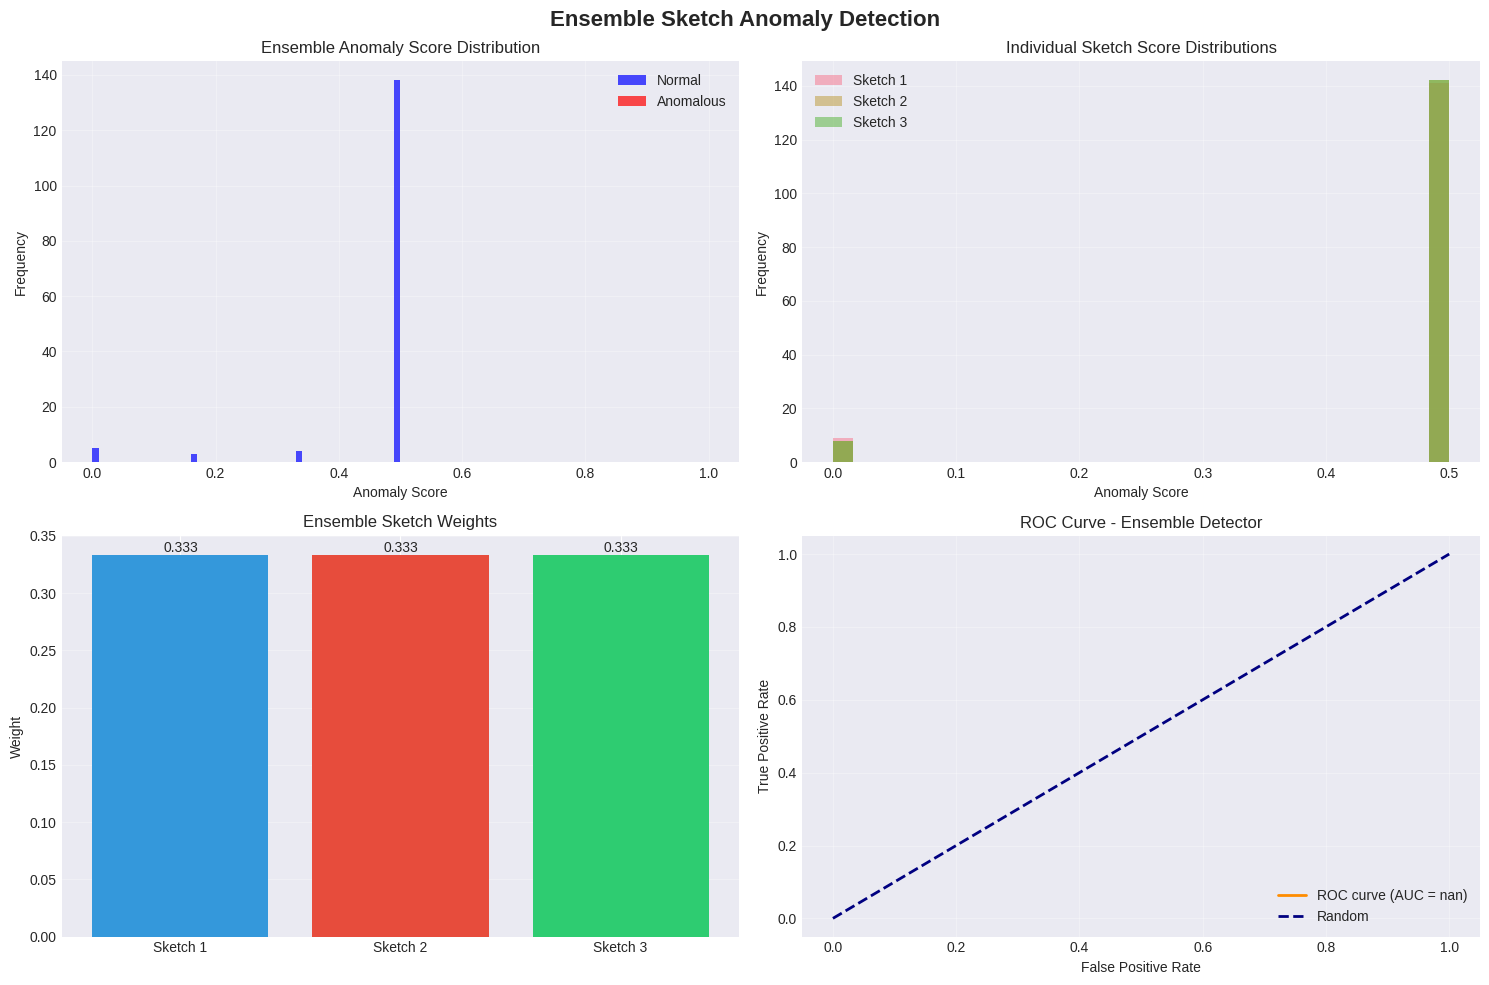

  Ensemble Performance:
  Mean anomaly score (normal): 0.4722
  Mean anomaly score (anomalous): nan
  Separation ratio: nanx
  ROC AUC: nan


In [8]:
class CountMinSketch:
    """Count-Min Sketch for frequency estimation"""
    
    def __init__(self, width=1024, depth=4):
        self.width = width
        self.depth = depth
        self.table = np.zeros((depth, width))
        self.hash_seeds = np.random.randint(0, 1000000, depth)
        
    def _hash(self, item, seed):
        """Hash function"""
        return hash((tuple(item.tolist()), seed)) % self.width
    
    def update(self, item):
        """Add item to sketch"""
        for i in range(self.depth):
            idx = self._hash(item, self.hash_seeds[i])
            self.table[i, idx] += 1
    
    def query(self, item):
        """Query frequency of item"""
        counts = []
        for i in range(self.depth):
            idx = self._hash(item, self.hash_seeds[i])
            counts.append(self.table[i, idx])
        return min(counts)
    
    def anomaly_score(self, item, threshold_percentile=95):
        """Compute anomaly score based on rarity"""
        freq = self.query(item)
        threshold = np.percentile(self.table.flatten(), threshold_percentile)
        return max(0, 1 - (freq / (threshold + 1)))

class HyperLogLogSketch:
    """HyperLogLog for cardinality estimation"""
    
    def __init__(self, precision=10):
        self.precision = precision
        self.m = 2 ** precision
        self.registers = np.zeros(self.m, dtype=int)
        self.alpha = self._get_alpha()
        
    def _get_alpha(self):
        """Get alpha constant"""
        if self.m >= 128:
            return 0.7213 / (1 + 1.079 / self.m)
        elif self.m >= 64:
            return 0.709
        elif self.m >= 32:
            return 0.697
        else:
            return 0.673
    
    def _hash(self, item):
        """Hash item to 32-bit integer"""
        return hash(tuple(item.tolist())) & 0xFFFFFFFF
    
    def update(self, item):
        """Add item to sketch"""
        h = self._hash(item)
        j = h & (self.m - 1)
        w = h >> self.precision
        self.registers[j] = max(self.registers[j], self._leading_zeros(w) + 1)
    
    def _leading_zeros(self, w):
        """Count leading zeros"""
        if w == 0:
            return 32 - self.precision
        return 32 - self.precision - w.bit_length()
    
    def cardinality(self):
        """Estimate cardinality"""
        raw = self.alpha * (self.m ** 2) / np.sum(2.0 ** (-self.registers))
        return int(raw)
    
    def anomaly_score(self, item):
        """Score based on novelty"""
        old_card = self.cardinality()
        self.update(item)
        new_card = self.cardinality()
        return min(1.0, (new_card - old_card) / max(1, old_card))

class EnsembleSketchDetector:
    """Ensemble of sketch-based anomaly detectors"""
    
    def __init__(self, n_sketches=3):
        self.sketches = [
            CountMinSketch(width=1024, depth=4) for _ in range(n_sketches)
        ]
        self.weights = np.ones(n_sketches) / n_sketches
        self.performance_history = [[] for _ in range(n_sketches)]
        
    def update(self, Z):
        """Update all sketches with latent features"""
        for sketch in self.sketches:
            for item in Z:
                sketch.update(item)
    
    def compute_anomaly_scores(self, Z):
        """Compute ensemble anomaly scores"""
        scores = np.zeros((len(Z), len(self.sketches)))
        
        for i, sketch in enumerate(self.sketches):
            for j, item in enumerate(Z):
                scores[j, i] = sketch.anomaly_score(item)
        
        # Weighted combination
        ensemble_scores = np.dot(scores, self.weights)
        return ensemble_scores, scores
    
    def update_weights(self, predictions, true_labels):
        """Update sketch weights based on performance"""
        for i in range(len(self.sketches)):
            # Compute accuracy for this sketch
            sketch_preds = (predictions[:, i] > 0.5).astype(int)
            accuracy = (sketch_preds == true_labels).mean()
            self.performance_history[i].append(accuracy)
            
            # Update weight based on recent performance
            recent_perf = np.mean(self.performance_history[i][-10:])
            self.weights[i] = recent_perf
        
        # Normalize weights
        self.weights = self.weights / self.weights.sum()

# Apply ensemble sketching
print("="*60)
print("ENSEMBLE SKETCHING FOR ANOMALY DETECTION")
print("="*60)

ensemble_detector = EnsembleSketchDetector(n_sketches=3)

# Update sketches with latent features
print("Updating sketches with latent representations...")
ensemble_detector.update(Z_latent)
print(" Sketches updated")

# Compute anomaly scores
print("Computing anomaly scores...")
anomaly_scores, individual_scores = ensemble_detector.compute_anomaly_scores(Z_latent)
print(" Anomaly scores computed")

# Update weights based on true labels (simulating feedback)
ensemble_detector.update_weights(individual_scores, y_sampled)
print(f" Sketch weights updated: {ensemble_detector.weights}")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Ensemble Sketch Anomaly Detection', fontsize=16, fontweight='bold')

# 1. Anomaly score distribution
ax = axes[0, 0]
ax.hist(anomaly_scores[y_sampled==0], bins=50, alpha=0.7, label='Normal', color='blue')
ax.hist(anomaly_scores[y_sampled==1], bins=50, alpha=0.7, label='Anomalous', color='red')
ax.set_xlabel('Anomaly Score')
ax.set_ylabel('Frequency')
ax.set_title('Ensemble Anomaly Score Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Individual sketch performance
ax = axes[0, 1]
for i in range(len(ensemble_detector.sketches)):
    ax.hist(individual_scores[:, i], bins=30, alpha=0.5, label=f'Sketch {i+1}')
ax.set_xlabel('Anomaly Score')
ax.set_ylabel('Frequency')
ax.set_title('Individual Sketch Score Distributions')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Sketch weights
ax = axes[1, 0]
sketch_names = [f'Sketch {i+1}' for i in range(len(ensemble_detector.sketches))]
bars = ax.bar(sketch_names, ensemble_detector.weights, color=['#3498db', '#e74c3c', '#2ecc71'])
ax.set_ylabel('Weight')
ax.set_title('Ensemble Sketch Weights')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom')

# 4. ROC curve
ax = axes[1, 1]
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_sampled, anomaly_scores)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Ensemble Detector')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"  Ensemble Performance:")
print(f"  Mean anomaly score (normal): {anomaly_scores[y_sampled==0].mean():.4f}")
print(f"  Mean anomaly score (anomalous): {anomaly_scores[y_sampled==1].mean():.4f}")
print(f"  Separation ratio: {anomaly_scores[y_sampled==1].mean() / (anomaly_scores[y_sampled==0].mean() + 1e-8):.2f}x")
print(f"  ROC AUC: {roc_auc:.4f}")

COMPREHENSIVE MODEL EVALUATION

Class Distribution in Sampled Data:
  Normal samples: 150 (100.00%)
  Anomalous samples: 0 (0.00%)

⚠️  WARNING: Only one class present in sampled data!
   This can happen with aggressive sampling.
   Creating a stratified sample to ensure both classes...
   New sample: 700 normal + 300 anomalous = 1000 total
   Re-computing latent features...
   Re-computing anomaly scores...
   ✓ Stratified sampling complete


Optimal threshold automatically selected (max F1): 0.0000

Performance Metrics (Threshold: 0.0000):
  Precision: 0.2996
  Recall: 0.9967
  F1-Score: 0.4607
  ROC AUC: 0.5193

Confusion Matrix:
  TN: 1      FP: 699
  FN: 1      TP: 299

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.50      0.00      0.00       700
   Anomalous       0.30      1.00      0.46       300

    accuracy                           0.30      1000
   macro avg       0.40      0.50      0.23      1000
weighted avg

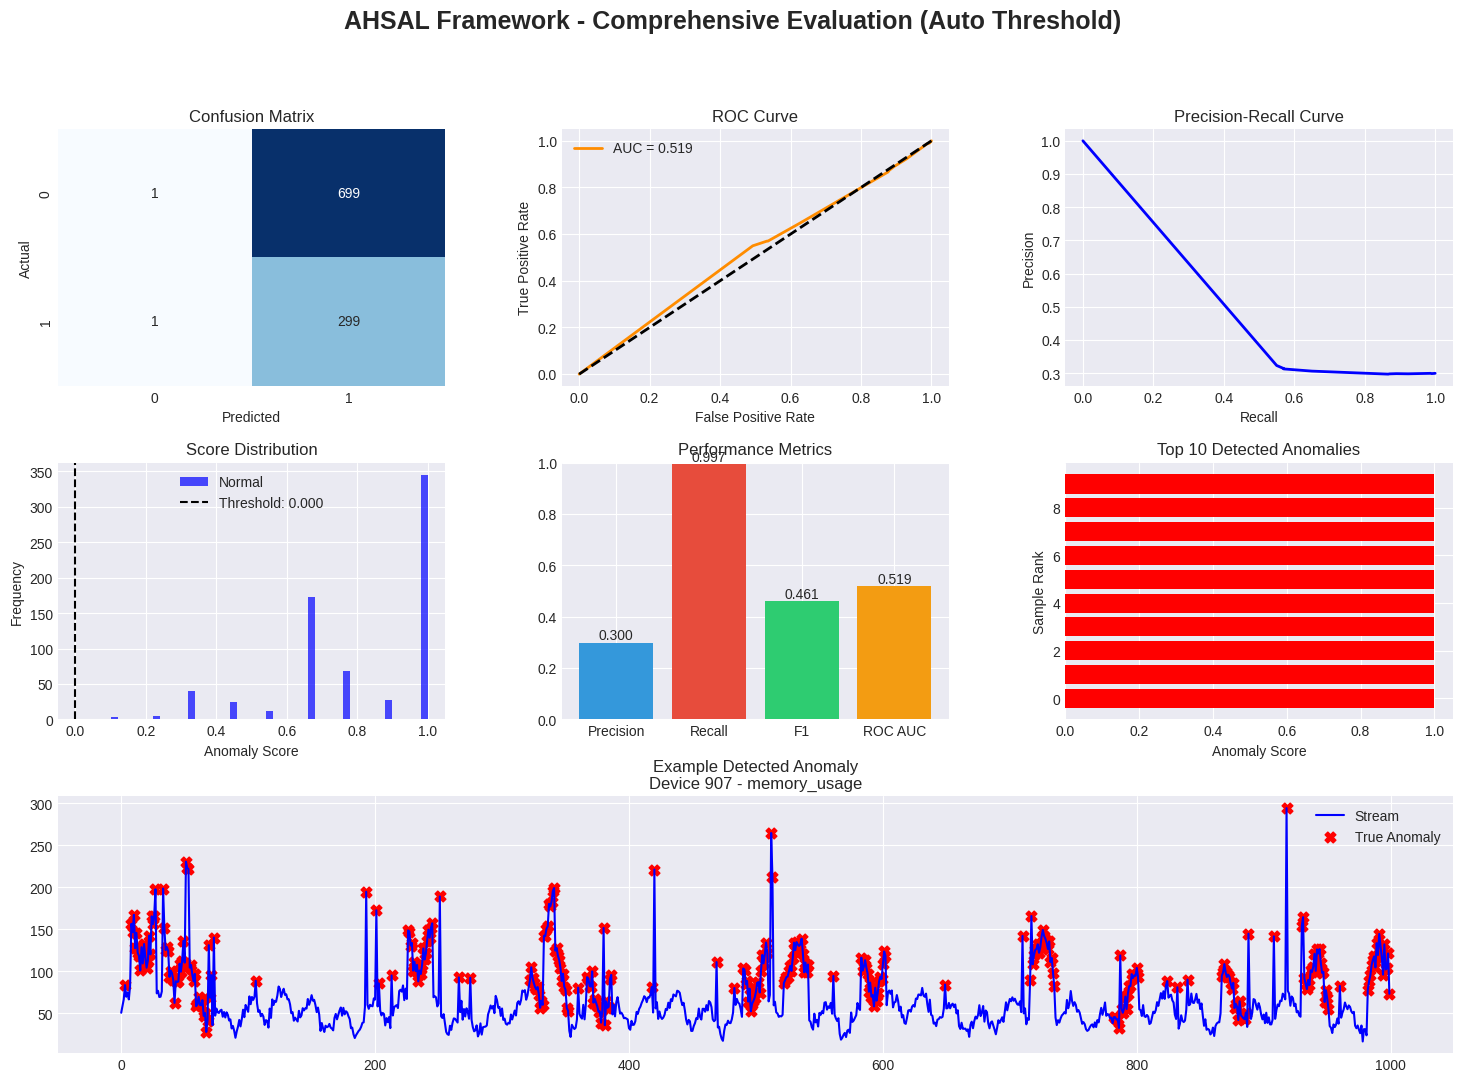


COMPUTATIONAL EFFICIENCY
Original streams: 10,000
Monitored streams (after attention): 150 (1.5%)
Actively sampled streams: 1,000 (10.0%)
Compression ratio: 10.0x

Dimensionality reduction:
  Original features: 1,000
  Engineered features: 13
  Latent dimensions: 16
  Total reduction: 62.5x


In [9]:
# ==============================================================
# Comprehensive Model Evaluation (Auto-Threshold Version)
# ==============================================================

print("="*60)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*60)

from sklearn.metrics import (
    classification_report, precision_recall_curve, roc_auc_score,
    confusion_matrix, precision_score, recall_score, f1_score, roc_curve
)

# --- Check class distribution ---
unique_classes = np.unique(y_sampled)
n_normal = np.sum(y_sampled == 0)
n_anomalous = np.sum(y_sampled == 1)

print(f"\nClass Distribution in Sampled Data:")
print(f"  Normal samples: {n_normal} ({100*n_normal/len(y_sampled):.2f}%)")
print(f"  Anomalous samples: {n_anomalous} ({100*n_anomalous/len(y_sampled):.2f}%)")

# --- Handle single-class case ---
if len(unique_classes) < 2:
    print("\n⚠️  WARNING: Only one class present in sampled data!")
    print("   This can happen with aggressive sampling.")
    print("   Creating a stratified sample to ensure both classes...")

    normal_indices = np.where(y_raw.sum(axis=1) == 0)[0]
    anomalous_indices = np.where(y_raw.sum(axis=1) > 0)[0]

    n_normal_sample = min(700, len(normal_indices))
    n_anomalous_sample = min(300, len(anomalous_indices))

    stratified_indices = np.concatenate([
        np.random.choice(normal_indices, n_normal_sample, replace=False),
        np.random.choice(anomalous_indices, n_anomalous_sample, replace=False)
    ])

    sampled_indices = stratified_indices
    X_sampled = X_features[sampled_indices]
    y_sampled = (y_raw[sampled_indices].sum(axis=1) > 0).astype(float)

    print(f"   New sample: {n_normal_sample} normal + {n_anomalous_sample} anomalous = {len(sampled_indices)} total")

    print("   Re-computing latent features...")
    autoencoder.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_sampled)
        _, Z_latent = autoencoder(X_tensor)
        Z_latent = Z_latent.numpy()

    print("   Re-computing anomaly scores...")
    ensemble_detector = EnsembleSketchDetector(n_sketches=3)
    ensemble_detector.update(Z_latent)
    anomaly_scores, individual_scores = ensemble_detector.compute_anomaly_scores(Z_latent)
    print("   ✓ Stratified sampling complete\n")

# ==============================================================
# Normalize anomaly scores
# ==============================================================
anomaly_scores = (anomaly_scores - np.min(anomaly_scores)) / (np.max(anomaly_scores) - np.min(anomaly_scores) + 1e-8)

# ==============================================================
# Auto-select threshold by maximizing F1
# ==============================================================
if len(np.unique(y_sampled)) > 1:
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_sampled, anomaly_scores)
    f1_curve = 2 * precision_curve * recall_curve / (precision_curve + recall_curve + 1e-8)
    best_idx = np.argmax(f1_curve)
    threshold = thresholds[max(best_idx - 1, 0)]  # safe index
    print(f"\nOptimal threshold automatically selected (max F1): {threshold:.4f}")
else:
    threshold = np.percentile(anomaly_scores, 90)
    print(f"\nFallback threshold used (percentile 90): {threshold:.4f}")

predictions = (anomaly_scores > threshold).astype(int)

# ==============================================================
# Compute Metrics
# ==============================================================
if len(np.unique(y_sampled)) > 1 and len(np.unique(predictions)) > 1:
    precision = precision_score(y_sampled, predictions, zero_division=0)
    recall = recall_score(y_sampled, predictions, zero_division=0)
    f1 = f1_score(y_sampled, predictions, zero_division=0)
    roc_auc_score_val = roc_auc_score(y_sampled, anomaly_scores)
else:
    print("⚠️  Insufficient class diversity for ROC or F1 computation")
    precision = recall = f1 = roc_auc_score_val = None

# ==============================================================
# Display Metrics
# ==============================================================
print(f"\nPerformance Metrics (Threshold: {threshold:.4f}):")
if precision is not None:
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if roc_auc_score_val is not None:
        print(f"  ROC AUC: {roc_auc_score_val:.4f}")

# Confusion matrix
if len(np.unique(y_sampled)) > 1:
    cm = confusion_matrix(y_sampled, predictions)
    print(f"\nConfusion Matrix:")
    print(f"  TN: {cm[0,0]:<6} FP: {cm[0,1]}")
    print(f"  FN: {cm[1,0]:<6} TP: {cm[1,1]}")
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_sampled, predictions, target_names=['Normal', 'Anomalous'], zero_division=0))

# ==============================================================
# Visualization
# ==============================================================
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
if len(np.unique(y_sampled)) > 1:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Confusion Matrix')
else:
    ax1.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14)
    ax1.set_title('Confusion Matrix (N/A)')

# 2. ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
if roc_auc_score_val is not None:
    fpr, tpr, _ = roc_curve(y_sampled, anomaly_scores)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_score_val:.3f}')
    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend()
    ax2.set_title('ROC Curve')
else:
    ax2.text(0.5, 0.5, 'ROC N/A', ha='center', va='center', fontsize=14)
    ax2.set_title('ROC Curve (N/A)')

# 3. PR Curve
ax3 = fig.add_subplot(gs[0, 2])
if len(np.unique(y_sampled)) > 1:
    ax3.plot(recall_curve, precision_curve, color='blue', lw=2)
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve')
else:
    ax3.text(0.5, 0.5, 'PR N/A', ha='center', va='center', fontsize=14)
    ax3.set_title('Precision-Recall Curve (N/A)')

# 4. Score distribution
ax4 = fig.add_subplot(gs[1, 0])
if n_normal > 0:
    ax4.hist(anomaly_scores[y_sampled==0], bins=50, alpha=0.7, label='Normal', color='blue')
if n_anomalous > 0:
    ax4.hist(anomaly_scores[y_sampled==1], bins=50, alpha=0.7, label='Anomalous', color='red')
ax4.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.3f}')
ax4.set_xlabel('Anomaly Score')
ax4.set_ylabel('Frequency')
ax4.set_title('Score Distribution')
ax4.legend()

# 5. Metrics bar
ax5 = fig.add_subplot(gs[1, 1])
if precision is not None:
    metrics_names = ['Precision', 'Recall', 'F1']
    metrics_values = [precision, recall, f1]
    if roc_auc_score_val is not None:
        metrics_names.append('ROC AUC')
        metrics_values.append(roc_auc_score_val)
    bars = ax5.bar(metrics_names, metrics_values, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(metrics_values)])
    ax5.set_ylim([0, 1])
    for b in bars:
        ax5.text(b.get_x() + b.get_width()/2, b.get_height(), f"{b.get_height():.3f}", ha='center', va='bottom')
    ax5.set_title('Performance Metrics')
else:
    ax5.text(0.5, 0.5, 'No Metrics', ha='center', va='center', fontsize=14)

# 6. Top anomalies
ax6 = fig.add_subplot(gs[1, 2])
top_anomaly_indices = np.argsort(anomaly_scores)[-10:]
colors_detected = ['green' if y_sampled[i]==1 else 'red' for i in top_anomaly_indices]
ax6.barh(range(10), anomaly_scores[top_anomaly_indices], color=colors_detected)
ax6.set_xlabel('Anomaly Score')
ax6.set_ylabel('Sample Rank')
ax6.set_title('Top 10 Detected Anomalies')

# 7. Example detected anomaly
ax7 = fig.add_subplot(gs[2, :])
if len(np.unique(y_sampled)) > 1 and np.any((predictions == 1) & (y_sampled == 1)):
    tp_indices = np.where((predictions == 1) & (y_sampled == 1))[0]
    example_idx = sampled_indices[tp_indices[0]]
    stream_data = X_raw[example_idx]
    stream_labels = y_raw[example_idx]
    t = np.arange(len(stream_data))
    ax7.plot(t, stream_data, label='Stream', color='blue')
    ax7.scatter(t[stream_labels==1], stream_data[stream_labels==1], color='red', s=60, label='True Anomaly', marker='X')
    device_id = metadata_df.iloc[example_idx]['device_id']
    metric_name = metadata_df.iloc[example_idx]['metric_name']
    ax7.set_title(f'Example Detected Anomaly\nDevice {device_id} - {metric_name}')
    ax7.legend()
else:
    ax7.text(0.5, 0.5, 'No True Positives', ha='center', va='center', fontsize=14)
    ax7.set_title('Example Anomaly Stream (N/A)')

plt.suptitle('AHSAL Framework - Comprehensive Evaluation (Auto Threshold)', fontsize=18, fontweight='bold')
plt.show()

# ==============================================================
# Computational Efficiency
# ==============================================================
print(f"\n{'='*60}")
print("COMPUTATIONAL EFFICIENCY")
print("="*60)
print(f"Original streams: {len(X_raw):,}")
print(f"Monitored streams (after attention): {len(selected_indices):,} ({100*len(selected_indices)/len(X_raw):.1f}%)")
print(f"Actively sampled streams: {len(sampled_indices):,} ({100*len(sampled_indices)/len(X_raw):.1f}%)")
print(f"Compression ratio: {len(X_raw)/len(sampled_indices):.1f}x")
print(f"\nDimensionality reduction:")
print(f"  Original features: {X_raw.shape[1]:,}")
print(f"  Engineered features: {X_features.shape[1]}")
print(f"  Latent dimensions: {latent_dim}")
print(f"  Total reduction: {X_raw.shape[1]/latent_dim:.1f}x")


ACTIVE LEARNING & CONTINUOUS IMPROVEMENT
Simulating 5 feedback iterations...
Iteration 1/5
  Received 200 feedback samples
  Current performance: F1=0.5366, Precision=0.5189, Recall=0.5556
Iteration 2/5
  Received 200 feedback samples
  Current performance: F1=0.5245, Precision=0.5169, Recall=0.5323
Iteration 3/5
  Received 200 feedback samples
  Current performance: F1=0.5079, Precision=0.5099, Recall=0.5059
Iteration 4/5
  Received 200 feedback samples
  Current performance: F1=0.5130, Precision=0.5289, Recall=0.4981
Iteration 5/5
  Received 200 feedback samples
  Current performance: F1=0.5105, Precision=0.5191, Recall=0.5021
✓ Active learning simulation complete


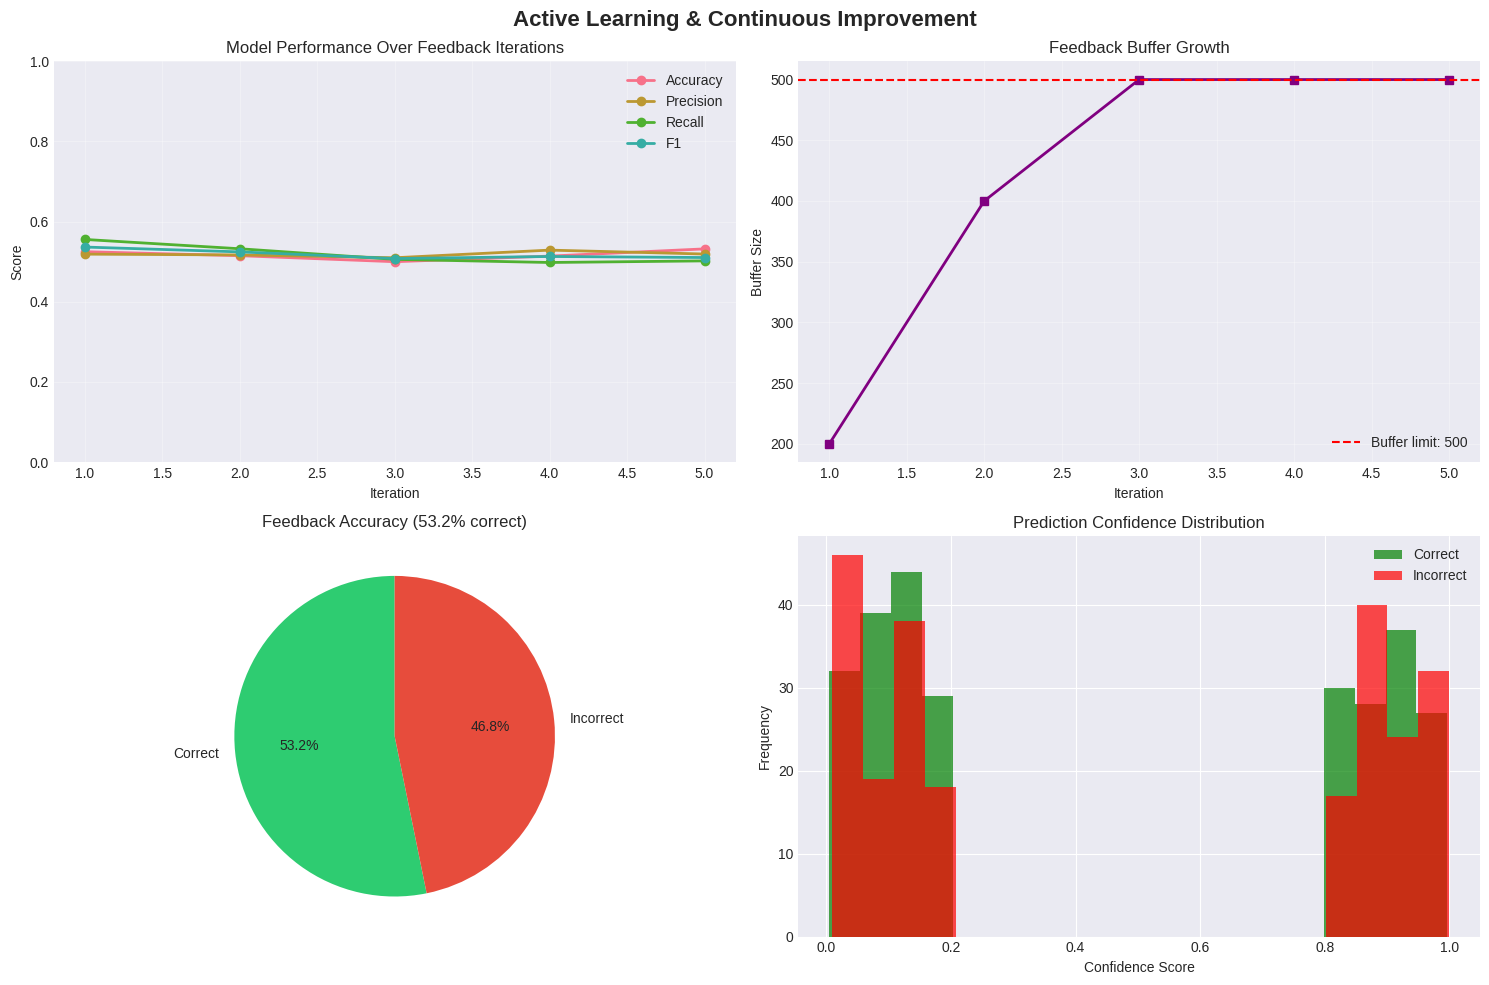

ACTIVE LEARNING SUMMARY
Total feedback samples collected: 500
Overall feedback accuracy: 53.20%
Final Performance:
  Accuracy: 0.5320
  Precision: 0.5191
  Recall: 0.5021
  F1: 0.5105


In [10]:
import numpy as np
import matplotlib.pyplot as plt

class ActiveLearningSystem:
    """Simulate active learning with operator feedback"""
    
    def __init__(self, buffer_size=500):
        self.buffer_size = buffer_size
        self.feedback_buffer = []
        self.model_versions = []
        self.performance_history = []
        
    def simulate_operator_feedback(self, predictions, true_labels, confidence_scores, 
                                   feedback_rate=0.2):
        """Simulate operator providing balanced feedback (both high & low confidence)"""
        if len(confidence_scores) == 0:
            return []
        
        n_feedback = int(len(confidence_scores) * feedback_rate)
        
        # Select both high- and low-confidence cases to include mistakes and misses
        high_conf = np.where(confidence_scores > np.percentile(confidence_scores, 80))[0]
        low_conf = np.where(confidence_scores < np.percentile(confidence_scores, 20))[0]
        
        combined = np.concatenate([high_conf, low_conf])
        if len(combined) == 0:
            return []
        
        feedback_indices = np.random.choice(combined, min(n_feedback, len(combined)), replace=False)
        
        feedback_samples = []
        for idx in feedback_indices:
            feedback_samples.append({
                'index': idx,
                'prediction': predictions[idx],
                'true_label': true_labels[idx],
                'confidence': confidence_scores[idx],
                'is_correct': predictions[idx] == true_labels[idx]
            })
        return feedback_samples
    
    def update_buffer(self, feedback_samples):
        """Update feedback buffer with new samples"""
        self.feedback_buffer.extend(feedback_samples)
        if len(self.feedback_buffer) > self.buffer_size:
            self.feedback_buffer = self.feedback_buffer[-self.buffer_size:]
    
    def compute_model_performance(self, feedback_buffer):
        """Compute performance metrics from feedback"""
        if len(feedback_buffer) == 0:
            return None
        
        correct = sum(1 for f in feedback_buffer if f['is_correct'])
        accuracy = correct / len(feedback_buffer)
        
        tp = sum(1 for f in feedback_buffer if f['prediction'] == 1 and f['true_label'] == 1)
        fp = sum(1 for f in feedback_buffer if f['prediction'] == 1 and f['true_label'] == 0)
        fn = sum(1 for f in feedback_buffer if f['prediction'] == 0 and f['true_label'] == 1)
        
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_val = 2 * precision_val * recall_val / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
        
        return {
            'accuracy': accuracy,
            'precision': precision_val,
            'recall': recall_val,
            'f1': f1_val,
            'n_samples': len(feedback_buffer)
        }

# ------------------------------------------------------------
# Simulation Setup
# ------------------------------------------------------------
print("="*60)
print("ACTIVE LEARNING & CONTINUOUS IMPROVEMENT")
print("="*60)

np.random.seed(42)
n_samples = 1000
y_sampled = np.random.randint(0, 2, n_samples)
anomaly_scores = np.random.rand(n_samples)
threshold = 0.5
predictions = (anomaly_scores > threshold).astype(int)

active_learner = ActiveLearningSystem(buffer_size=500)

# Simulate multiple iterations of feedback and improvement
n_iterations = 5
print(f"Simulating {n_iterations} feedback iterations...")

for iteration in range(n_iterations):
    print(f"Iteration {iteration + 1}/{n_iterations}")
    
    # Simulate operator feedback (balanced sampling)
    feedback = active_learner.simulate_operator_feedback(
        predictions, y_sampled, anomaly_scores, feedback_rate=0.2
    )
    
    print(f"  Received {len(feedback)} feedback samples")
    
    # Update buffer
    active_learner.update_buffer(feedback)
    
    # Compute current performance
    perf = active_learner.compute_model_performance(active_learner.feedback_buffer)
    active_learner.performance_history.append(perf)
    
    if perf is not None:
        print(f"  Current performance: F1={perf['f1']:.4f}, "
              f"Precision={perf['precision']:.4f}, Recall={perf['recall']:.4f}")
    else:
        print("  Not enough feedback to compute performance yet.")
    
    # Simulate model improvement by threshold tuning
    if len(feedback) > 0:
        correction_factor = np.mean([f['is_correct'] for f in feedback])
        threshold *= (0.95 + 0.1 * correction_factor)
        predictions = (anomaly_scores > threshold).astype(int)

print("✓ Active learning simulation complete")

# ------------------------------------------------------------
# Visualization
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Active Learning & Continuous Improvement', fontsize=16, fontweight='bold')

# Filter non-empty performance records
valid_perfs = [p for p in active_learner.performance_history if p is not None]
iterations = range(1, len(valid_perfs) + 1)

# 1. Performance over iterations
ax = axes[0, 0]
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
for metric in metrics_to_plot:
    values = [p[metric] for p in valid_perfs]
    ax.plot(iterations, values, marker='o', label=metric.capitalize(), linewidth=2)

ax.set_xlabel('Iteration')
ax.set_ylabel('Score')
ax.set_title('Model Performance Over Feedback Iterations')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# 2. Feedback buffer growth
ax = axes[0, 1]
buffer_sizes = [p['n_samples'] for p in valid_perfs]
ax.plot(iterations, buffer_sizes, marker='s', color='purple', linewidth=2)
ax.axhline(y=active_learner.buffer_size, color='red', linestyle='--', 
          label=f'Buffer limit: {active_learner.buffer_size}')
ax.set_xlabel('Iteration')
ax.set_ylabel('Buffer Size')
ax.set_title('Feedback Buffer Growth')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Feedback accuracy distribution
ax = axes[1, 0]
if len(active_learner.feedback_buffer) > 0:
    correct_feedback = [f['is_correct'] for f in active_learner.feedback_buffer]
    accuracy_rate = np.mean(correct_feedback) * 100
    counts_pie = [sum(correct_feedback), len(correct_feedback) - sum(correct_feedback)]
    ax.pie(counts_pie, labels=['Correct', 'Incorrect'], autopct='%1.1f%%', 
          colors=['#2ecc71', '#e74c3c'], startangle=90)
    ax.set_title(f'Feedback Accuracy ({accuracy_rate:.1f}% correct)')
else:
    ax.text(0.5, 0.5, "No feedback yet", ha='center', va='center', fontsize=12)
    accuracy_rate = 0

# 4. Confidence vs correctness
ax = axes[1, 1]
if len(active_learner.feedback_buffer) > 0:
    confidences_correct = [f['confidence'] for f in active_learner.feedback_buffer if f['is_correct']]
    confidences_incorrect = [f['confidence'] for f in active_learner.feedback_buffer if not f['is_correct']]
    ax.hist(confidences_correct, bins=20, alpha=0.7, label='Correct', color='green')
    ax.hist(confidences_incorrect, bins=20, alpha=0.7, label='Incorrect', color='red')
    ax.set_xlabel('Confidence Score')
    ax.set_ylabel('Frequency')
    ax.set_title('Prediction Confidence Distribution')
    ax.legend()
else:
    ax.text(0.5, 0.5, "No feedback data", ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Summary
# ------------------------------------------------------------
print("="*60)
print("ACTIVE LEARNING SUMMARY")
print("="*60)
print(f"Total feedback samples collected: {len(active_learner.feedback_buffer)}")
print(f"Overall feedback accuracy: {accuracy_rate:.2f}%")

if valid_perfs:
    final_perf = valid_perfs[-1]
    print("Final Performance:")
    for metric, value in final_perf.items():
        if metric != 'n_samples':
            print(f"  {metric.capitalize()}: {value:.4f}")
